##### Estadisticas generales sobre el covid-19

In [1]:
from utilidades import *

# data, aggregated_mobility, local_mobility = lazy_load_data('tarija')
data, aggregated_mobility, local_mobility = lazy_load_data()
x = range(len(data[0]))

##### Casos

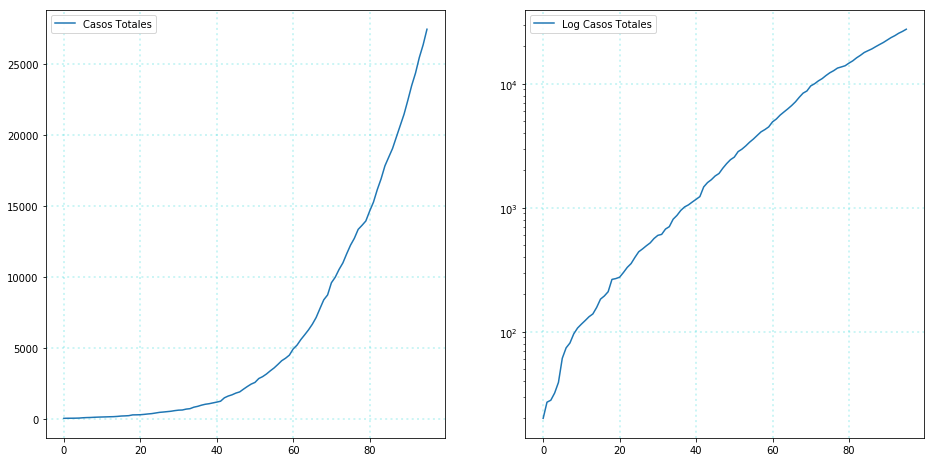

In [2]:
def stylize_ax(ax):
    if type(ax) == np.ndarray:
        [stylize_ax(_) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    ax.legend(loc='upper left')

fig, axs = pyplot.subplots(ncols=2, nrows=1)

axs[0].plot(x, data[1], label='Casos Totales')
axs[1].plot(x, data[1], label='Log Casos Totales')
axs[1].set_yscale('log')

stylize_ax(axs)

In [3]:
local_data = load_data(aggregate=False)
local_data_index = pd.MultiIndex.from_product(
    [local_data.keys(), ['active_cases', 'cases', 'death', 'recovered', 'tests']]
)

local_data = pd.DataFrame(it.chain(*local_data.values())).T
local_data.columns = local_data_index

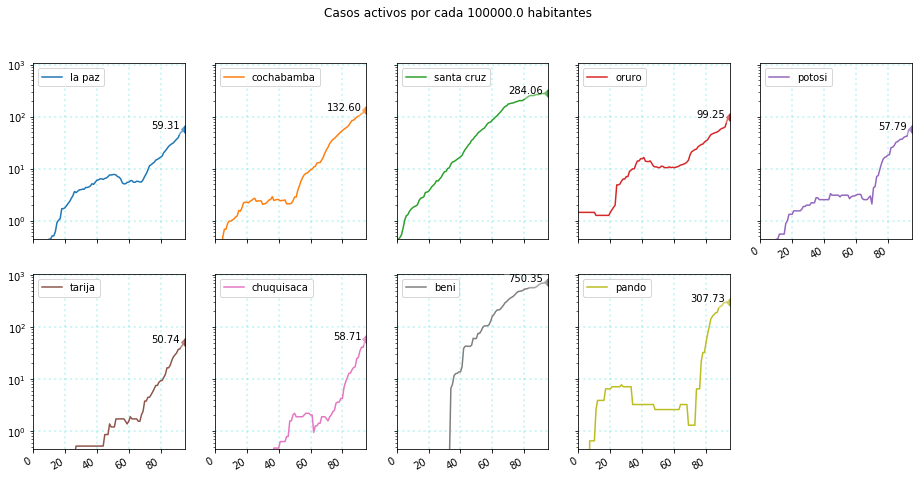

In [4]:
def stylize_subplots_axs(axs):
    for yaxs in axs:
        if isinstance(yaxs, matplotlib.axes._subplots.Axes):
            yaxs = [yaxs]
        
        for ax in yaxs:
            if not ax.lines:
                continue
            
            for series in ax.lines[:]:
                last_value = pd.Series(series.get_ydata())
                last_value_idx = last_value.last_valid_index()
                
                if not last_value_idx or not last_value[last_value_idx]:
                    continue
                    
                last_value = last_value[last_value_idx]

                ax.plot(
                    last_value_idx, 
                    last_value, 
                    marker='D', 
                    color=series.get_color()
                )
                
                ax.annotate(
                    '{:0.2f}'.format(last_value), 
                    xy=(1, last_value), xytext=(-5, 0), 
                    ha="right",
                    xycoords=('axes fraction', 'data'), 
                    textcoords='offset points',
                    bbox={
                        'edgecolor': 'none',
                        'facecolor': 'white', 
                        'alpha': 0.3
                    }
                )
            
            ax.legend(loc='upper left')
            ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)

local_active_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'active_cases']]
scale_to = 1e5
cases_limit = 10

population = load_population_data(1, group_by=2).items()
population = dict([(_[1].lower(), int(__['total'])) for _, __ in population])
population_adjust = [scale_to / population[_] for _, __ in local_active_cases.columns]

local_active_cases = (local_active_cases * population_adjust)
local_active_cases = local_active_cases
local_active_cases.columns = local_active_cases.columns.droplevel(1)

axs = local_active_cases.plot(
    title='Casos activos por cada {0} habitantes'.format(scale_to),
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
    logy=True
)
stylize_subplots_axs(axs)

In [5]:
def accumulate(arr, nth = 5):
    pad_arr = np.pad(
        arr, 
        (nth - len(arr) % nth, 0), 
        'constant', 
        constant_values=(0,)
    )
    return np.reshape(pad_arr, (-1, nth)).sum(axis=-1)

def plot_accumulated(x, y = None, label = '', nth = 5):
    if not y:
        y = x
        x = range(len(y))
        
    fig, ax = pyplot.subplots()
    ax.stem(x, y, label=label)
    
    cum_y = accumulate(y, nth)
    cum_y = np.repeat(cum_y, nth)[-1 * len(x):]
    
    ax2 = ax.twinx()
    ax2.step(x, cum_y, color='green', label='{} (Acumulado {} dias)'.format(label, nth))
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    if label:
        fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
        
    return ax

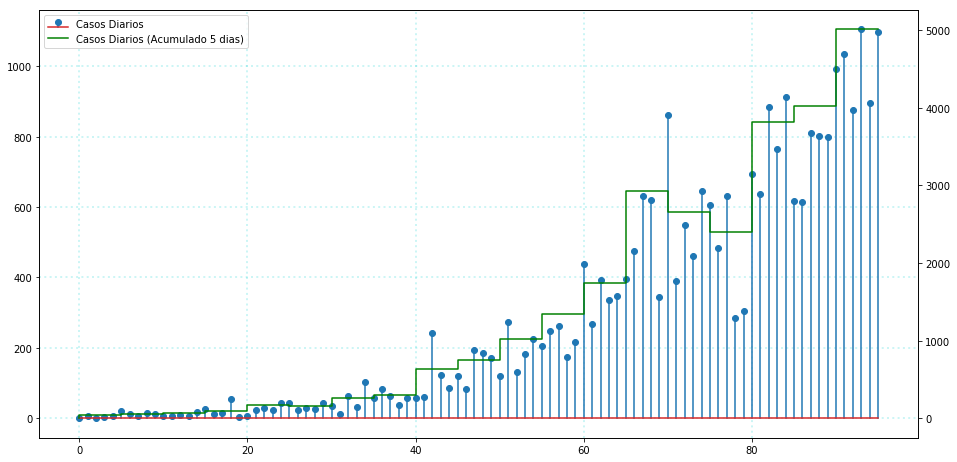

In [6]:
new_cases = np.diff(data[1], prepend=[data[1][0]])
_ = plot_accumulated(new_cases, label='Casos Diarios')

###### R_t 

avg Rt m1 (30d): 1.2391685411918247
r_ts[-1]: 1.1933677775261933 +- 0.07285565766595403

avg Rt m2 (30d): 1.1733181569781719
r_ts[-1]: 1.089510993632104 +- 0.19039166361258705


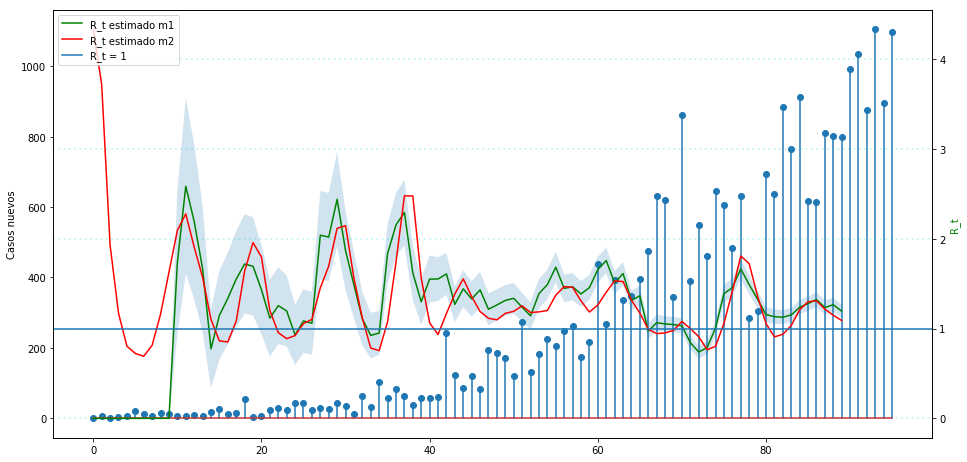

In [7]:
r_ts, r_ts_min, r_ts_max = estimate_rt(new_cases, window_size=3)

fig, ax = pyplot.subplots()
ax.stem(new_cases)
ax.set_ylabel('Casos nuevos')

ax2 = ax.twinx()
ax2.set_ylabel('R_t', color='green')
ax2.plot(r_ts, color='green', label='R_t estimado m1')
ax2.fill_between(
    range(len(r_ts)),
    r_ts_min,
    r_ts_max,
    alpha=0.2
)

print('avg Rt m1 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts[r_ts > 0][-30:]),
    r_ts[-1], r_ts_max[-1] - r_ts[-1]
))

def estimate_rt_2(new_cases, window_size=0):
    rts = []
    if window_size > 0:
        new_cases = moving_average(new_cases, window_size)
                
    for idx in range(7, len(new_cases) + 1):
        rt = sum(new_cases[idx - 3: idx]) / max(1., sum(new_cases[idx - 7:idx - 4]))
        rts.append(rt)
        
    rts = np.array(rts)
    rts[rts > 6.] = 6.
    
    return rts

r_ts_2 = estimate_rt_2(new_cases, window_size=3)
ax2.plot(r_ts_2, color='red', label='R_t estimado m2')
print('\navg Rt m2 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts_2[r_ts_2 > 0][-30:]), 
    r_ts_2[-1], np.std(r_ts_2[-7:]) * 2.
))

ax2.axhline(1., label='R_t = 1')
stylize_ax(ax2)

Refs   
[1]: https://stochastik-tu-ilmenau.github.io/COVID-19/reports/repronum/repronum.pdf   
[2]: https://biocomsc.upc.edu/en/covid-19/Methods.pdf/view

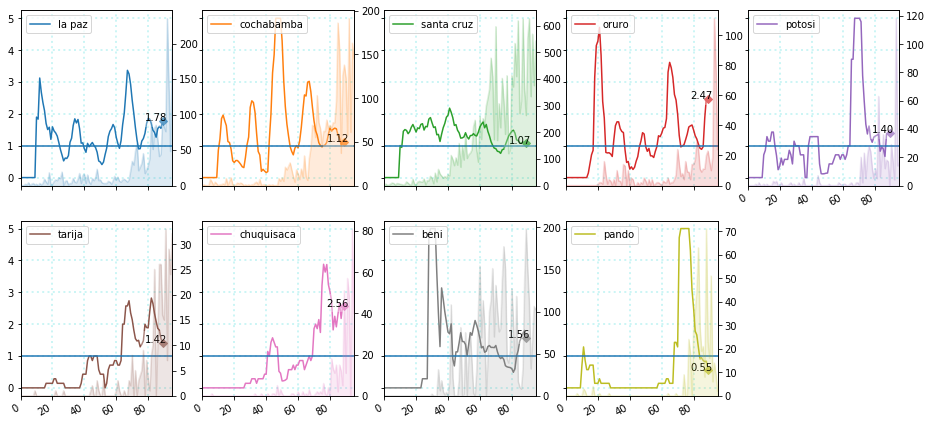

In [8]:
local_new_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'cases']].diff()
local_new_cases[local_new_cases < 0] = 0
local_new_cases.columns = local_new_cases.columns.droplevel(1) 
local_new_cases_averaged = local_new_cases.rolling(window=7).mean()

local_rts = pd.DataFrame()

for column in local_new_cases_averaged.columns:
    r_ts, r_ts_min, r_ts_max = estimate_rt(local_new_cases_averaged[column].fillna(0))
    local_rts[column] = np.pad(r_ts, (0, 6), 'constant', constant_values=(np.nan,))
    
local_rts[local_rts > 5] = 5
axs = local_rts.plot(
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
)
stylize_subplots_axs(axs)

for yaxs in axs:
        for ax in yaxs:
            ax.axhline(1.)
            
axs = local_new_cases.plot(
    kind='area', 
    ax=[ax.twinx() for ax in axs.flatten()[:-1]], 
    subplots=True,
    alpha=0.15
)

for ax in axs:
    ax.get_legend().remove()

Tiempo de duplicacion

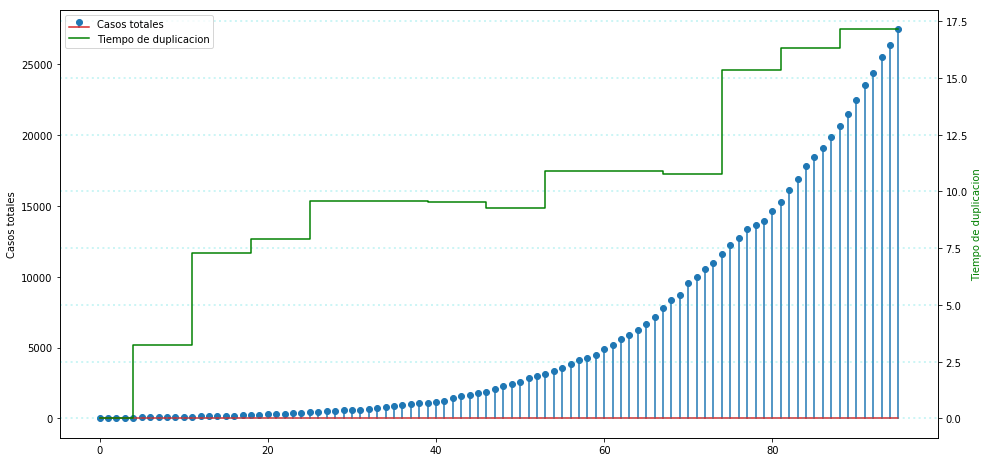

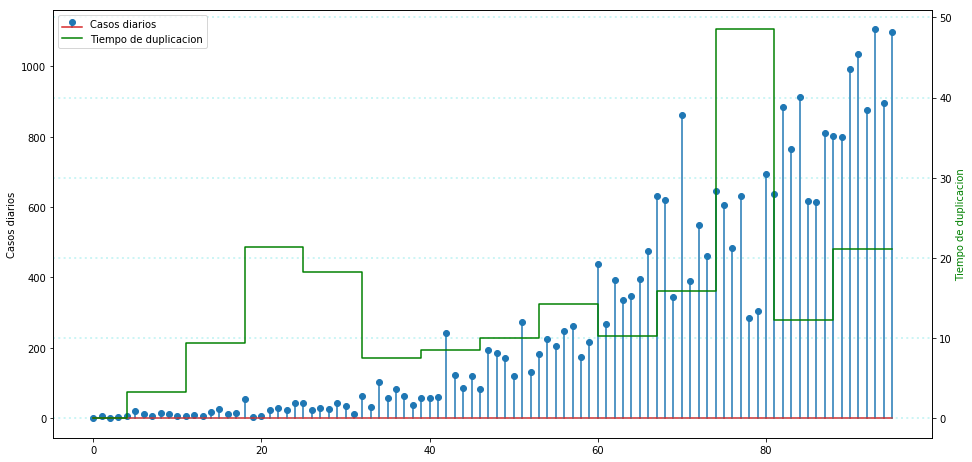

In [9]:
NTH = 7

# razon_incremento^x = 2
def doubling_times(arr):
    dts = [0]
    cum_arr = accumulate(arr, nth=NTH)
    
    for idx in range(1, len(cum_arr)):
        diff = max(
            1, cum_arr[idx] / max(1., cum_arr[idx - 1])
        )
        dts.append(NTH * np.log(2) / max(.1, np.log(diff)))
    
    return dts

def draw_doubling(arr, title=''):
    dts = doubling_times(arr)
    dts = np.repeat(dts, NTH)[-1 * len(arr):]

    fig, ax = pyplot.subplots()
    p1 = ax.stem(arr, label=title)
    ax.set_ylabel(title)

    ax2 = ax.twinx()
    ax2.set_ylabel('Tiempo de duplicacion', color='green')
    p2 = ax2.step(range(len(dts)), dts, color='green', label='Tiempo de duplicacion')

    pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
    
draw_doubling(data[1], title='Casos totales')
draw_doubling(new_cases, title='Casos diarios')

###### Movilidad

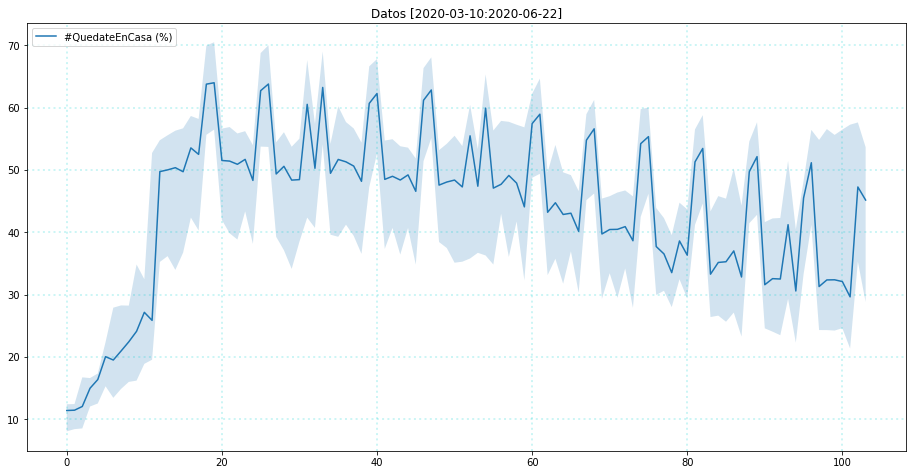

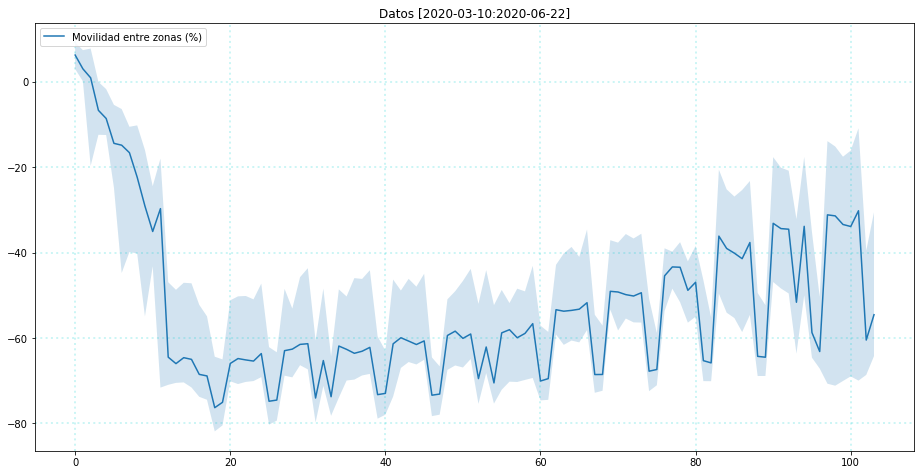

In [10]:
def plot_with_min_max(global_mobility, local_mobility, title):
    global_mobility = global_mobility.loc['2020-03-10':]
    local_mobility = local_mobility.loc['2020-03-10':]
    
    ax = plot(
        range(len(global_mobility)), 
        global_mobility * 100, 
        labels=[title]
    )
    
    ax.fill_between(
        range(len(global_mobility)),
        local_mobility.min(axis=1) * 100,
        local_mobility.max(axis=1) * 100,
        alpha=0.2
    )
    
    ax.set_title('Datos [{}:{}]'.format(
        global_mobility.index[0], global_mobility.index[-1]
    ))
    
    return ax
    
if aggregated_mobility:
    visited_tiles_change, single_tile_ratio = aggregated_mobility
    visited_tiles_change_local, single_tile_ratio_local = local_mobility
    
    plot_with_min_max(single_tile_ratio, single_tile_ratio_local, '#QuedateEnCasa (%)')
    plot_with_min_max(visited_tiles_change, visited_tiles_change_local, 'Movilidad entre zonas (%)')

Cambio en el comportamiento respecto a febrero.   
Fuente: https://data.humdata.org/dataset/movement-range-maps   
   
En la <a href='https://research.fb.com/blog/2020/06/protecting-privacy-in-facebook-mobility-data-during-the-covid-19-response/'>metodologia</a> facebook aclara que: `Only people who opt in to Location History and background location collection are included`   


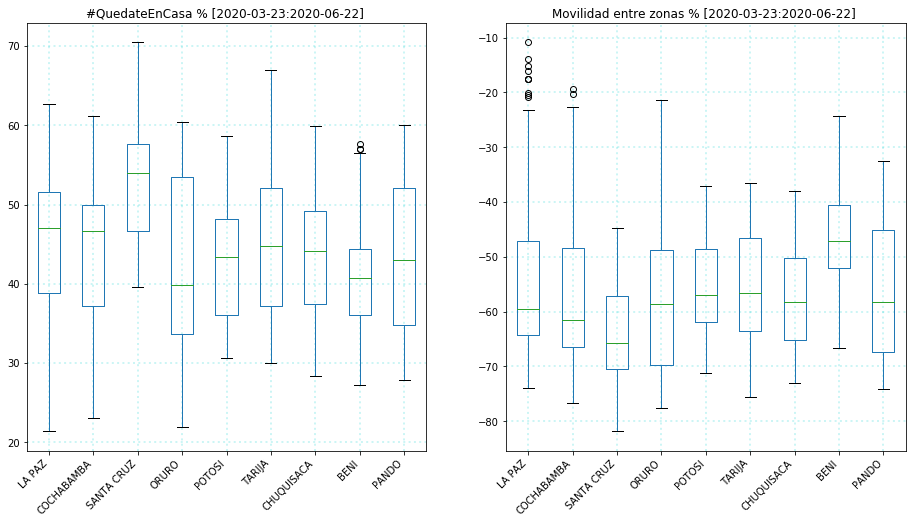

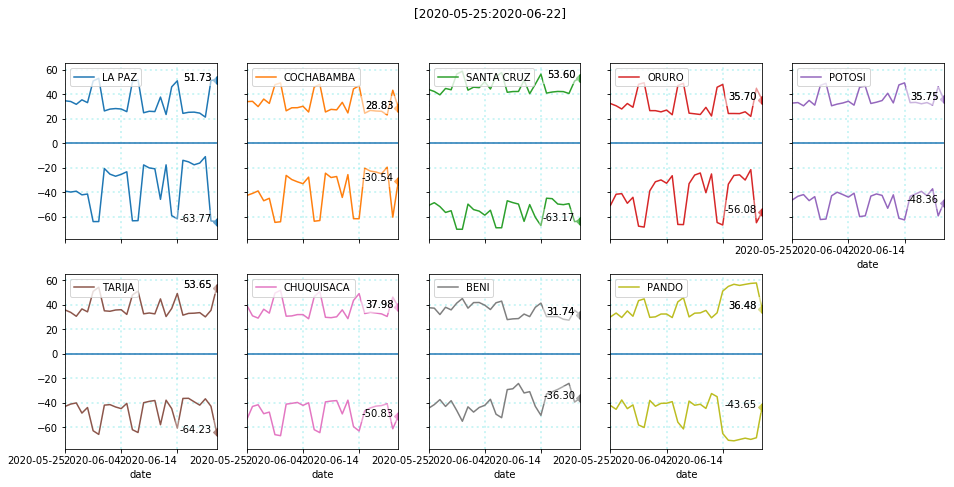

In [11]:
def draw_boxplot(data, title, ax):
    data = data.loc['2020-03-23':] * 100
    data.boxplot(ax=ax)
    ax.set_title('{} % [{}:{}] '.format(
        title,
        data.iloc[0].name, 
        data.iloc[-1].name
    ))
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

def plot_latest(data, nth=7, axs=None):
    latest_data = data.tail(nth) * 100
    
    if axs is None:
        axs = latest_data.plot(
            title='[{}:{}]'.format(
                latest_data.iloc[0].name, 
                latest_data.iloc[-1].name
            ),
            subplots=True, 
            layout=(2,5), 
            sharey=True, 
        )
        
    else:
        axs = latest_data.plot(
            ax=axs.flatten()[:-1] if axs is not None else None,
            subplots=True, 
            legend=False
        )
        
    stylize_subplots_axs(axs)
    
    for ax in axs:
        if isinstance(ax, matplotlib.axes._subplots.Axes):
            ax.axhline(0)
            
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            
            ax.legend(
                by_label.values(), 
                by_label.keys(), 
                loc='upper left'
            )
    
    return axs

if local_mobility:
    fig, axs = pyplot.subplots(ncols=2, nrows=1)
    column_order = [_.upper() for _ in local_data.columns.get_level_values(0).drop_duplicates()]
    
    single_tile_ratio_local = single_tile_ratio_local[column_order]
    visited_tiles_change_local = visited_tiles_change_local[column_order]
    
    draw_boxplot(single_tile_ratio_local, title='#QuedateEnCasa', ax=axs[0])
    draw_boxplot(visited_tiles_change_local, title='Movilidad entre zonas', ax=axs[1])
    
    axs = plot_latest(single_tile_ratio_local, nth=28)
    plot_latest(visited_tiles_change_local, nth=28, axs=axs)

##### Fallecidos

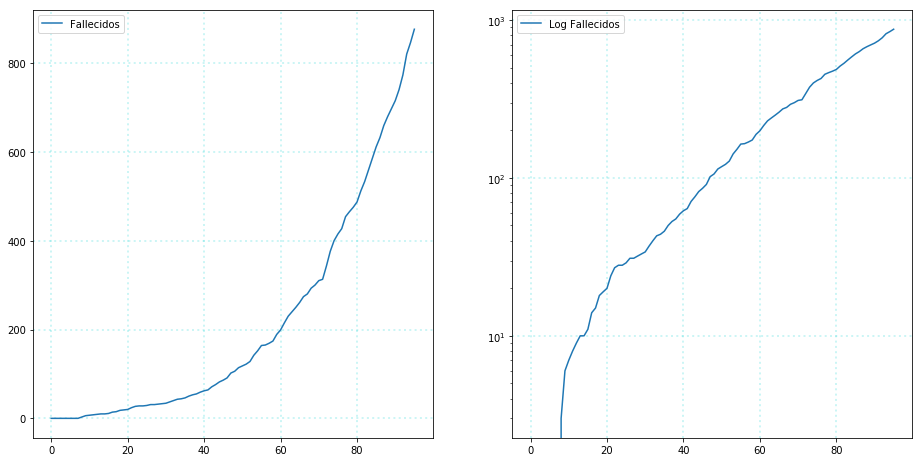

In [12]:
fig, axs = pyplot.subplots(ncols=2, nrows=1)

axs[0].plot(x, data[2], label='Fallecidos')
axs[1].plot(x, data[2], label='Log Fallecidos')
axs[1].set_yscale('log')

stylize_ax(axs)

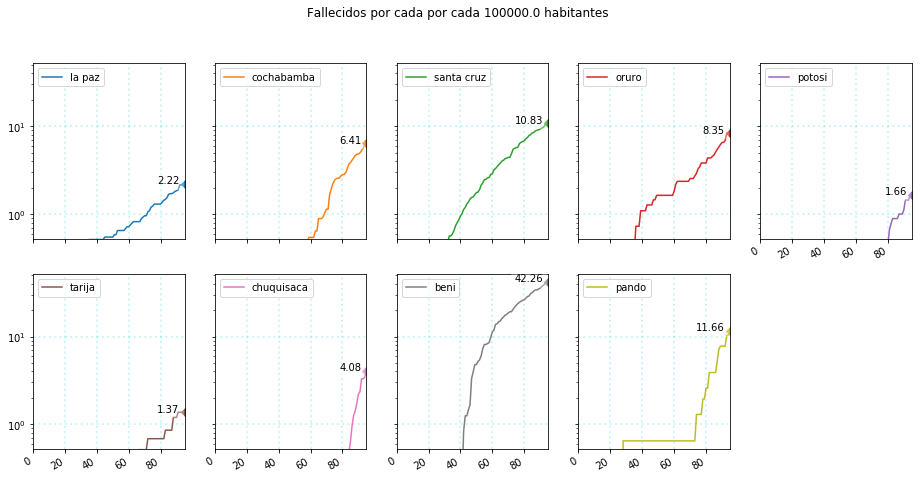

In [13]:
local_deaths_adjusted = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'death']]
local_deaths_adjusted = (local_deaths_adjusted * population_adjust)
local_deaths_adjusted.columns = local_deaths_adjusted.columns.droplevel(1)

axs = local_deaths_adjusted.plot(
    title='Fallecidos por cada por cada {0} habitantes'.format(scale_to),
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
    logy=True
)
stylize_subplots_axs(axs)

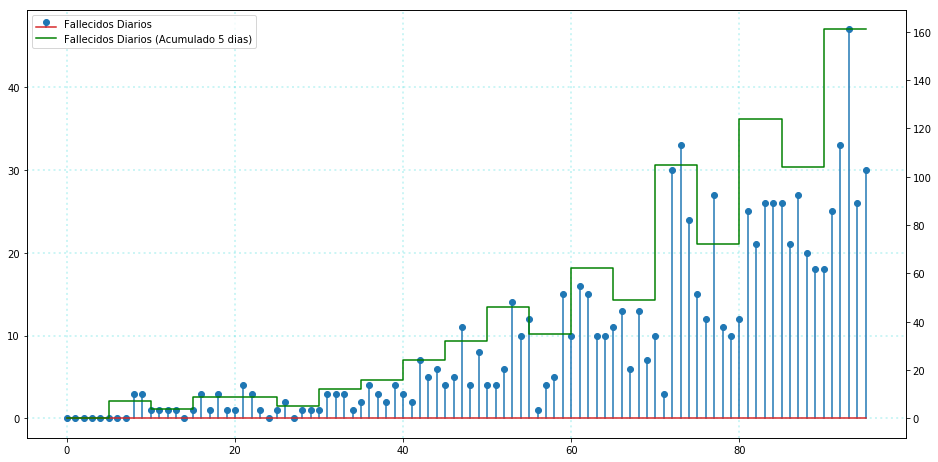

In [14]:
new_deaths = np.diff(data[2], prepend=[data[2][0]])
_ = plot_accumulated(new_deaths, label='Fallecidos Diarios')

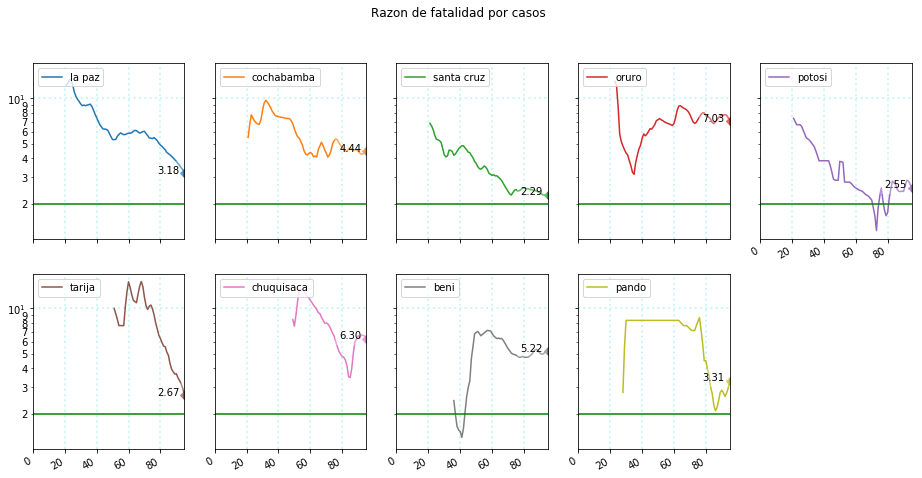

In [15]:
limit_local_cases = 10

local_deaths = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'death']]
local_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'cases']]

local_cases = pd.DataFrame(local_cases)
local_cases = local_cases[local_cases >= limit_local_cases]

local_deaths.columns = local_deaths.columns.droplevel(1) 
local_cases.columns = local_cases.columns.droplevel(1)

cfr = (100 * local_deaths / local_cases)
cfr = cfr.rolling(window=3).mean()
cfr[cfr == 0] = np.nan
cfr[:21] = np.nan

axs = cfr.plot(
    title='Razon de fatalidad por casos',
    subplots=True, 
    layout=(2,5), 
    sharey=True, 
    logy=True
)
stylize_subplots_axs(axs)

for yaxs in axs:
    for ax in yaxs:
        ax.axhline(2., color='green')
        ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

Tiempo de Duplicacion

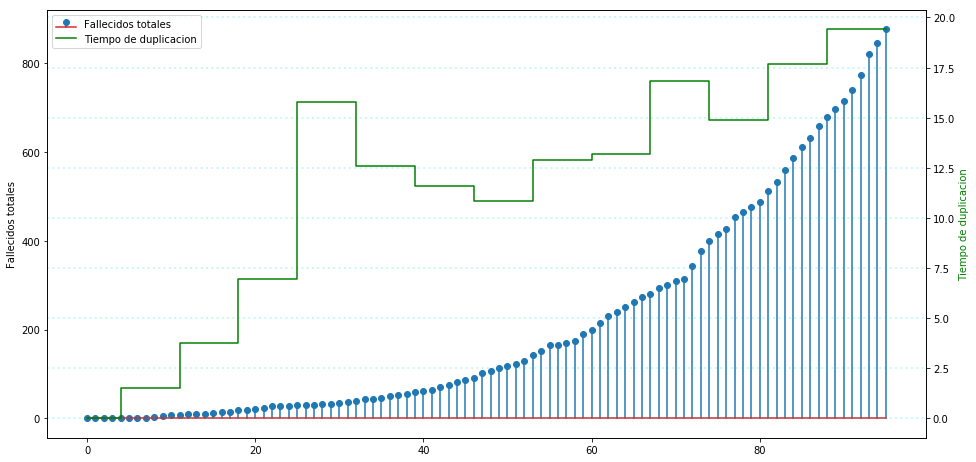

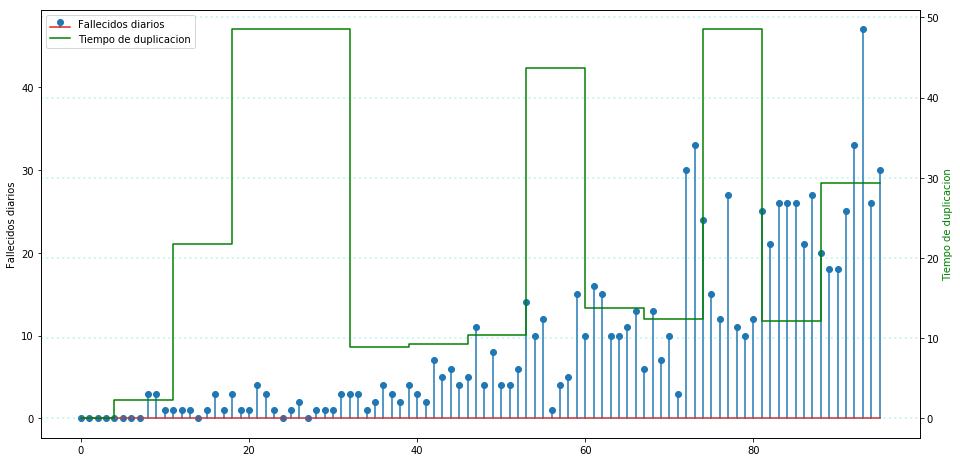

In [16]:
draw_doubling(data[2], title='Fallecidos totales')
draw_doubling(new_deaths, title='Fallecidos diarios')

###### Recuperados 

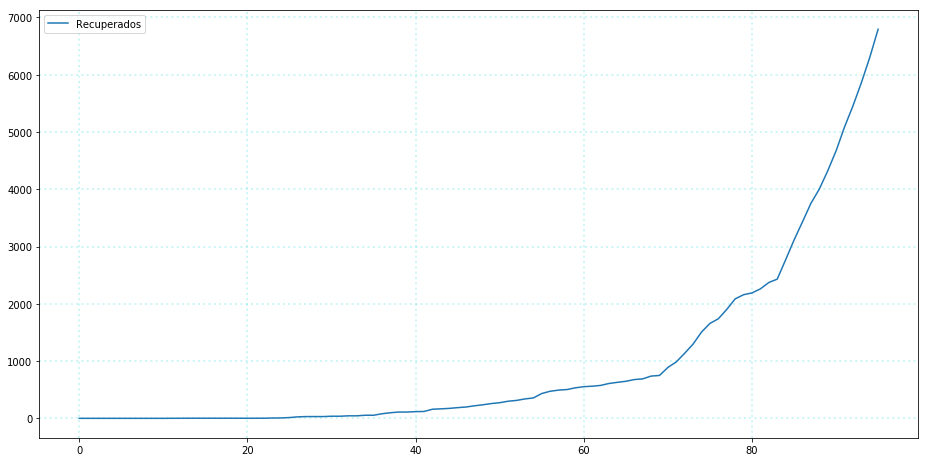

In [17]:
_ = plot(x, data[3], labels=['Recuperados'])

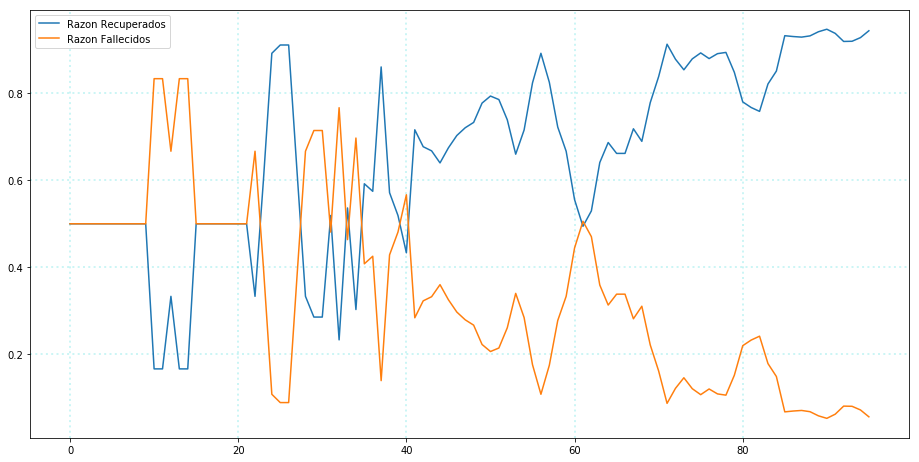

In [18]:
new_recovered = np.diff(data[3], prepend=[data[3][0]])

closed_cases = new_recovered + new_deaths
closed_cases[closed_cases < 1] = 1

recovered_rate = new_recovered / closed_cases
recovered_rate = moving_average(recovered_rate, 3)
recovered_rate[recovered_rate < .001] = .5

_ = plot(
    x, recovered_rate, 1 - recovered_rate,
    labels=['Razon Recuperados', 'Razon Fallecidos']
)

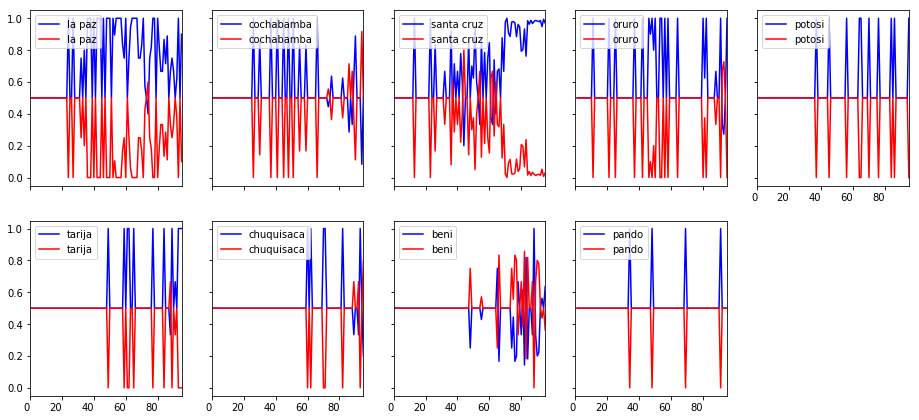

In [38]:
local_recovered = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'recovered']].diff()
local_recovered.columns = local_recovered.columns.droplevel(1)

new_local_deaths = local_deaths.diff()

closed_cases = local_recovered.add(new_local_deaths)
closed_cases[closed_cases < 1] = 1

local_recovered_rate = local_recovered / closed_cases
local_recovered_rate.rolling(window=7).mean()
local_recovered_rate[local_recovered_rate < .001] = .5

axs = local_recovered_rate.plot(
    color='blue',
    subplots=True, 
    layout=(2,5), 
    sharey=True
)
_ = (1 - local_recovered_rate).plot(color='red', ax=axs.flatten()[:-1], subplots=True)

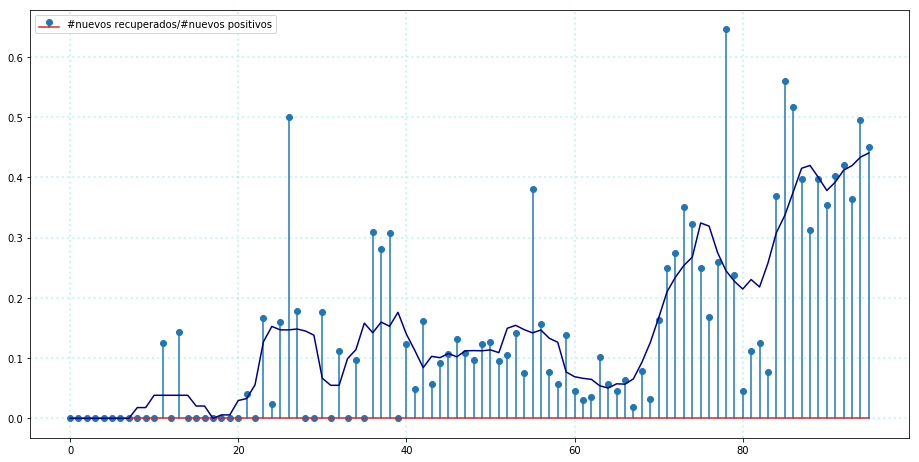

In [19]:
new_cases[new_cases < 1] = 1
recovered_to_new_cases = new_recovered / new_cases
recovered_to_new_cases[recovered_to_new_cases < 0] = 0
recovered_to_new_cases[recovered_to_new_cases > 6] = 6

ax = plot_moving_averaged(
    recovered_to_new_cases,
    label='#nuevos recuperados/#nuevos positivos',
    window_size = 7
)

##### Tests

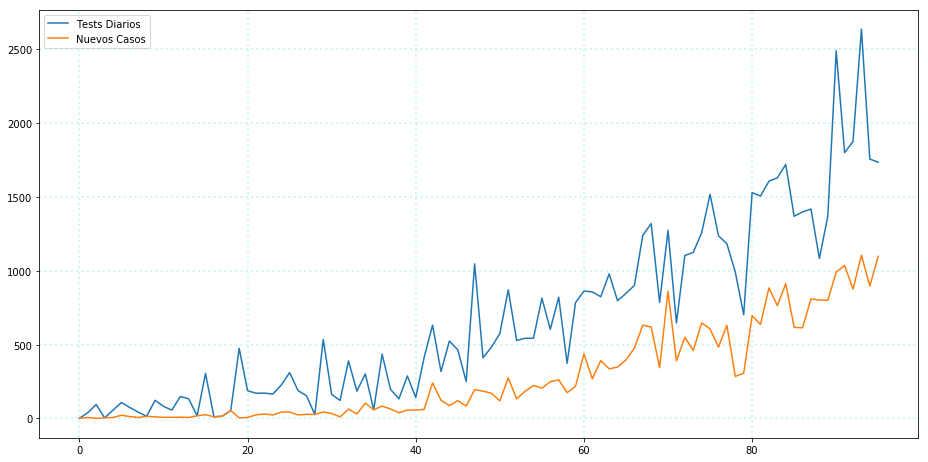

In [20]:
daily_tests = np.diff(data[-1], prepend=[data[-1][0]])
daily_tests[daily_tests < 1] = new_cases[daily_tests < 1]
_ = plot(x, daily_tests, new_cases, labels=['Tests Diarios', 'Nuevos Casos'])

Tests Diarios = <a href='https://github.com/mauforonda/covid19-bolivia/blob/master/descartados.csv'>Descartados</a> + <a href='https://github.com/mauforonda/covid19-bolivia2/blob/master/nacional.csv'>Nuevos Casos</a> + Recuperados   
Como referencia el 04/24, en el <a href='https://www.boliviasegura.gob.bo/comunicados_proc.php?Seleccion=23'>reporte del ministerio</a> indica que '4.490 casos fueron descartados mediante pruebas de laboratorio', misma cantidad que esta en los datos compilados por <a href='https://github.com/mauforonda'>@mauforonda</a>.  
Los datos a partir del 2020-05-02 fueron recogidos y procesados por la revista <a href='https://muywaso.com/especial-de-datos-muy-waso-sobre-el-coronavirus-en-bolivia/'>muywaso.com</a>.

Cuantos tests se necesitan para encontar un caso positivo?

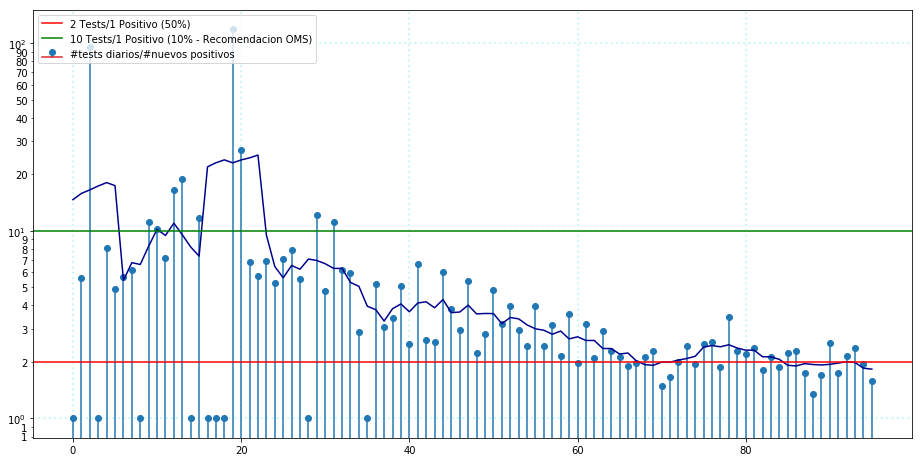

In [21]:
ax = plot_moving_averaged(
    daily_tests / new_cases, 
    label='#tests diarios/#nuevos positivos',
    window_size = 7
)
ax.axhline(2., label='2 Tests/1 Positivo (50%)', color='red')
ax.axhline(10., label='10 Tests/1 Positivo (10% - Recomendacion OMS)', color='green')

ax.set_yscale('log')
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
_ = ax.legend(loc='upper left')

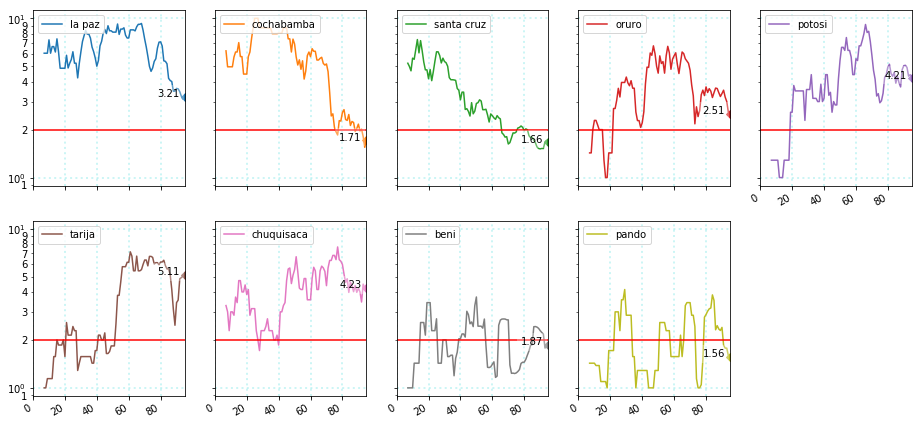

In [22]:
local_new_cases[local_new_cases < 1] = 1

local_daily_tests = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'tests']].diff()
local_daily_tests.columns = local_daily_tests.columns.droplevel(1)
local_daily_tests[local_daily_tests < 0] = 0

test_case_ratio = local_daily_tests / local_new_cases
test_case_ratio[test_case_ratio < 1] = 1
test_case_ratio[test_case_ratio > 10] = 10
test_case_ratio = test_case_ratio.rolling(window=7).mean()

axs = test_case_ratio.plot(subplots=True, layout=(2,5), sharey=True, logy=True)
stylize_subplots_axs(axs)

for yaxs in axs:
    for ax in yaxs:
        ax.axhline(2., color='red')
        ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

###### Seguimiento de contactos

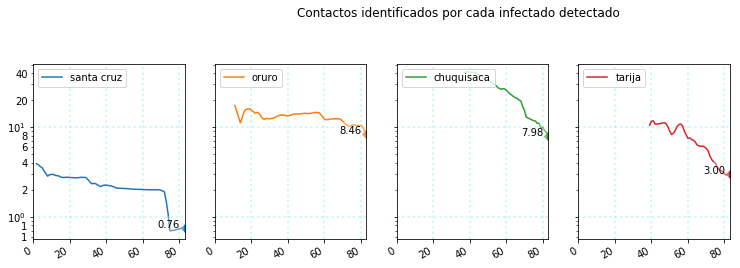

In [23]:
traced_contacts = pd.read_csv('./data/contact.tracing.csv')
traced_contacts = traced_contacts.iloc[:, 1:]
traced_contacts.columns = [do_process_label(_) for _ in traced_contacts.columns]

selected_local_cases = local_cases.iloc[-1 * len(traced_contacts):][traced_contacts.columns]
selected_local_cases = selected_local_cases.reset_index().iloc[:, 1:]

contacts_by_case = traced_contacts / selected_local_cases
contacts_by_case = contacts_by_case.rolling(window=3).mean()

axs = contacts_by_case.plot(
    title='Contactos identificados por cada infectado detectado',
    subplots=True,
    layout=(2,5),
    sharey=True,
    logy=True
)
stylize_subplots_axs(axs)

for yaxs in axs:
    for ax in yaxs:
        ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        for idx, tick in enumerate(ax.yaxis.get_minor_ticks()):
            if idx % 2 == 0:
                continue
                
            tick.label1.set_visible(False)

* La cantidad de contactos es mayor en Tarija, el sedes reporta los contactos activos (serie con adiciones y substracciones), el total solo se puede estimar.   
* No se encontro datos de otros departamentos.

Es dificil escoger un minimo aqui, depende mucho de la definicion de contacto, que porcentaje de contactos contagiados no detectados es aceptable y de la calidad de las entrevistas y el seguimiento.   
<a href='https://www.medrxiv.org/content/10.1101/2020.02.14.20023036v1'>Esta investigacion</a> recomienda ~ 30.

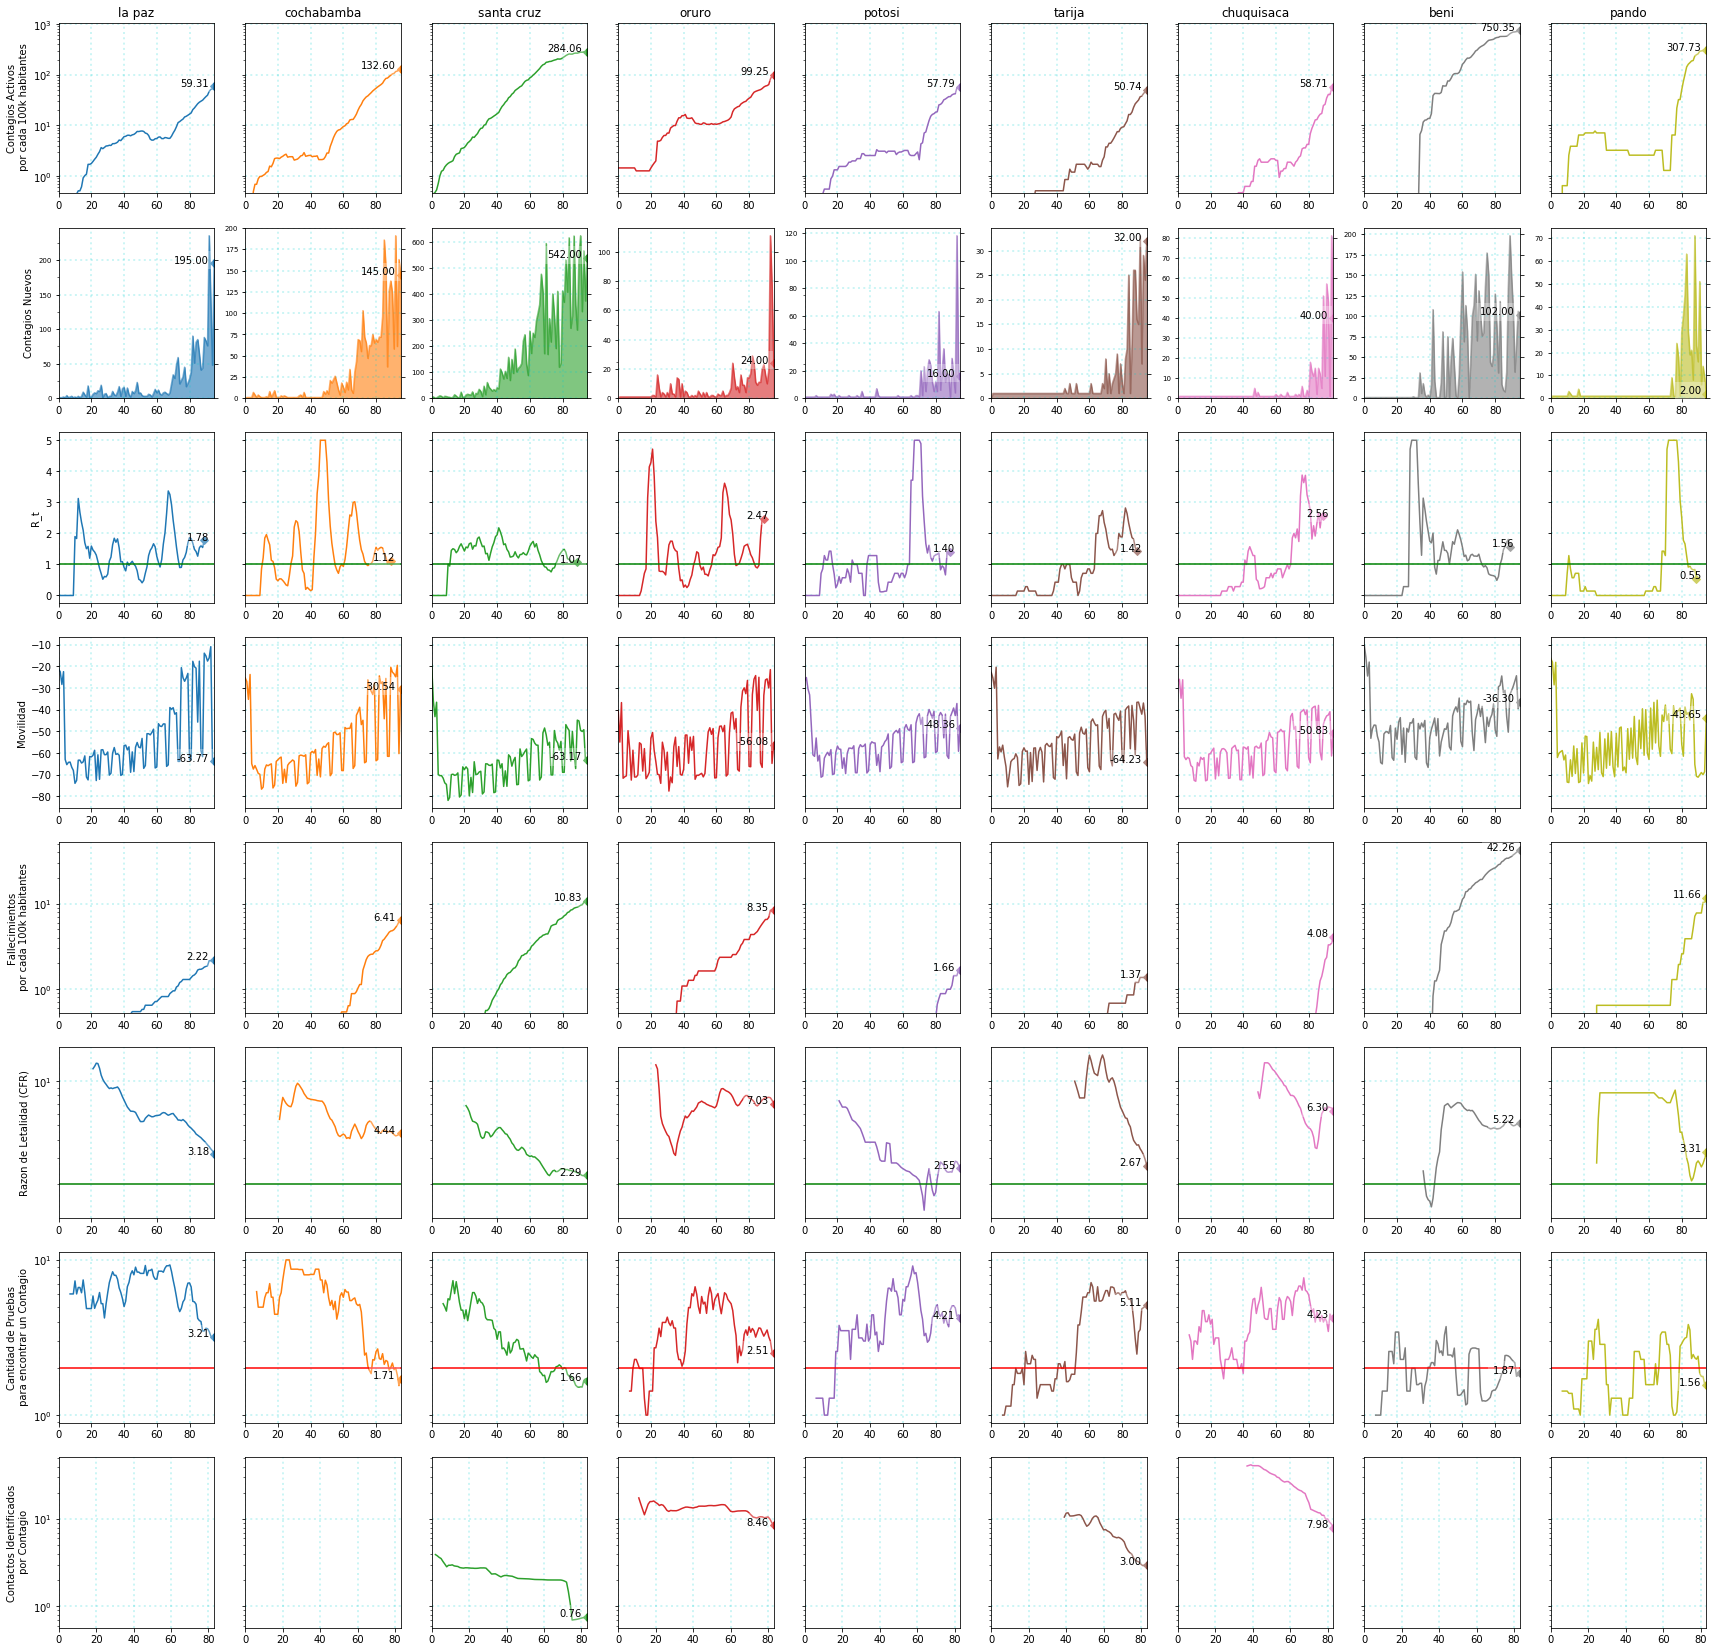

In [24]:
visited_tiles_change_local_timed = visited_tiles_change_local.tail(len(local_rts)).reset_index()

for column in local_rts.columns:
    if column and column not in contacts_by_case.columns:
        holder = np.zeros(len(contacts_by_case), dtype=float)
        holder.fill(np.nan)
        
        contacts_by_case[column] = holder
        
contacts_by_case = contacts_by_case[local_rts.columns]

VAR_NAMES = [
    'Contagios Activos\n por cada 100k habitantes',
    'Contagios Nuevos',
    'R_t',
    'Movilidad',
    'Fallecimientos\n por cada 100k habitantes',
    'Razon de Letalidad (CFR)',
    'Cantidad de Pruebas\n para encontrar un Contagio',
    'Contactos Identificados\n por Contagio'
]

VARS = [
    (local_active_cases, {'logy': True}),
    (local_new_cases, {
        'sharey': False, 
        'kind': 'area', 
        'alpha': .6,
    }),
    (local_rts, {'limit': (1, None)}),
    visited_tiles_change_local_timed * 100,
    (local_deaths_adjusted, {'logy': True}),
    (cfr, {'limit': (2, None), 'logy': True}),
    (test_case_ratio, {'limit': (None, 2), 'logy': True}),
    (contacts_by_case, {'logy': True})
]

fig, axs = pyplot.subplots(
    ncols=9, 
    nrows=len(VARS), 
    sharey='row',
    figsize=(75/2.54, 75/2.54)
)

for idx, row_axs in enumerate(axs):
    if type(VARS[idx]) == tuple:
        row_data, params = VARS[idx]
    else:
        row_data, params = VARS[idx], {}
        
    if 'sharey' in params:
        if not params['sharey']:
            shay = row_axs[0].get_shared_y_axes()
            for ax in row_axs:
                shay.remove(ax)
                yticker = matplotlib.axis.Ticker()
                
                ax.yaxis.major = yticker
                ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
                ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
                
                ax.tick_params(axis='y', reset=True, labelsize=7)
            
        del params['sharey']
    
    limit = None
    if 'limit' in params:
        limit = params['limit'] 
        del params['limit']
        
    row_data.plot(ax=row_axs, subplots=True, **params)
    stylize_subplots_axs(row_axs)
    
    # :S
    if limit is not None:
        lgood, lbad = limit
        
        if lgood is not None:
            for ax in row_axs:
                ax.axhline(lgood, color='green')
                
        if lbad is not None:
            for ax in row_axs:
                ax.axhline(lbad, color='red')
    
for yax in axs:
    for ax in yax:
        ax.get_legend().remove()
        
for ax, col in zip(axs[0], local_rts.columns):
    ax.set_title(col)
    
for ax, row in zip(axs[:, 0], VAR_NAMES):
    ax.set_ylabel(row)
    
fig.savefig('./img/latest.png', bbox_inches='tight')


Datos que faltarian:
* Porcentaje de los detectados diarios que son contactos de un infectado ya detectado.
    * Nro de contactos o si fuera posible, distribucion del # de contactos registrados
    * Lugares donde se dan esas transmisiones (hogar, trabajo, reunion, ...) relacionado al # de contactos (buscando clusters)
* Ocupacion de camas hospitales, cuidados intermedios, terapia intensiva, aislados en centros (como en <a href='https://github.com/mauforonda/covid19-lapaz-establecimientos'>La Paz</a>)
* Porcentaje de los fallecidos que no fueron atendidos en hospital o fallecieron a poco de llegar.    
* Historico de fallecimientos estos meses, historico de fallecimientos de otros anhos.